In [36]:
#Импортирую библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [5]:
#Считываю данные
assessments = pd.read_csv('assessments.csv')
courses = pd.read_csv('courses.csv')
studentAssessment = pd.read_csv('studentAssessment.csv')
studentRegistration = pd.read_csv('studentRegistration.csv')

In [11]:

studentAssessment.shape

(173912, 5)

In [12]:
assessments.shape

(206, 6)

In [14]:
#Всего 173 null значения в оценках из 173912, не так много.
studentAssessment.isnull().sum()

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

In [17]:
#Нужно сджоинить таблицу с информацией об оценках в тесте с информацией о результатах тестирования студентов
full_assessment = studentAssessment.merge(assessments, how = 'left', on = 'id_assessment')

In [21]:
full_assessment.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0
3,1752,32885,26,0,69.0,AAA,2013J,TMA,19.0,10.0
4,1752,38053,19,0,79.0,AAA,2013J,TMA,19.0,10.0


In [40]:
full_assessment.query("assessment_type == 'Exam'")

array(['CCC', 'DDD'], dtype=object)

In [27]:
#Посмотрю на то, какое количество студентов завершило модули
completed_modules = (full_assessment.query("assessment_type == 'Exam' and score >= 40")
                                   .groupby('code_module', as_index = False)
                                   .agg(students = ('id_student', 'nunique'))
                                   .sort_values('students', ascending = False))

In [28]:
#Можно увидеть, что есть всего 2 модуля c экзаменами. DDD успешно закончило 2706 студентов, CCC - 1683
completed_modules.head()

,code_module,students
1,DDD,2706
0,CCC,1683


In [41]:
#Посмотрю на то, какое количество студентов поступило на модуль
students_count = (full_assessment.query("assessment_type == 'Exam'")
                                   .groupby('code_module', as_index = False)
                                   .agg(all_students = ('id_student', 'nunique'))
                                   .sort_values('all_students', ascending = False))

In [42]:
students_count.head()

,code_module,all_students
1,DDD,3040
0,CCC,1915


In [46]:
#Теперь создам дф, в котором посмотрю на то, какой процент людей успешно сдали модуль.
exam_df = completed_modules.merge(students_count, how = 'left', on = 'code_module')
exam_df['successful_percent'] = (exam_df.students*100)/exam_df.all_students
exam_df.head()

,code_module,students,all_students,successful_percent
0,DDD,2706,3040,89.013158
1,CCC,1683,1915,87.885117


Можно заметить, что большинство студентов успешно завершают модуль.

In [50]:
#Теперь хочется понять какое количество тестов в семестре с разбивкой по предмету(модулю). 

assessments_count = (full_assessment.query("assessment_type !='Exam'") #Исключу экзамены, посмотрю только промежуточные
                                   .groupby(['code_presentation', 'code_module'],as_index = False)
                                   .agg(assessments_count = ('id_assessment', 'nunique'))
                                   .sort_values('assessments_count', ascending = False))

In [51]:
assessments_count.head()

,code_presentation,code_module,assessments_count
1,2013B,DDD,13
2,2013B,FFF,12
20,2014J,FFF,12
13,2014B,FFF,12
7,2013J,FFF,12


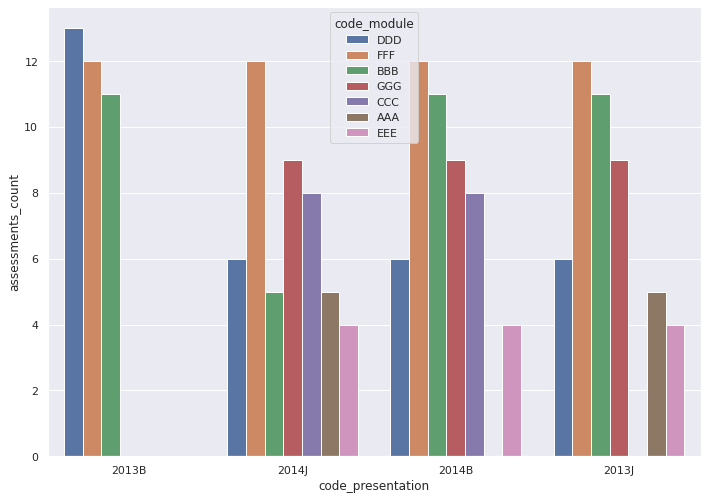

In [52]:
#Визуализирую полученную информацию
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data = assessments_count,x = 'code_presentation', y = 'assessments_count', hue = 'code_module')

Можно заметить, что количество тестов по разным предметам по семестрам различается. Какие-то предметы (Например, DDD) являются базовыми и находятся во всех семестрах, какие-то предметы есть только в определенных семестрах. Выяснилось, что экзамены есть только в двух предметах (DDD, CCC)

In [58]:
#Теперь посмотрю на количество студентов по семестрам. Таким образом я попытаюсь сгруппировать семестры в курс.

students_by_semester = (full_assessment.groupby('code_presentation', as_index = False)
                                       .agg(num_students = ('id_student', 'nunique'))
                                       .sort_values('num_students', ascending = False))


students_by_semester.head().head()

,code_presentation,num_students
3,2014J,8613
1,2013J,7098
2,2014B,5748
0,2013B,3803


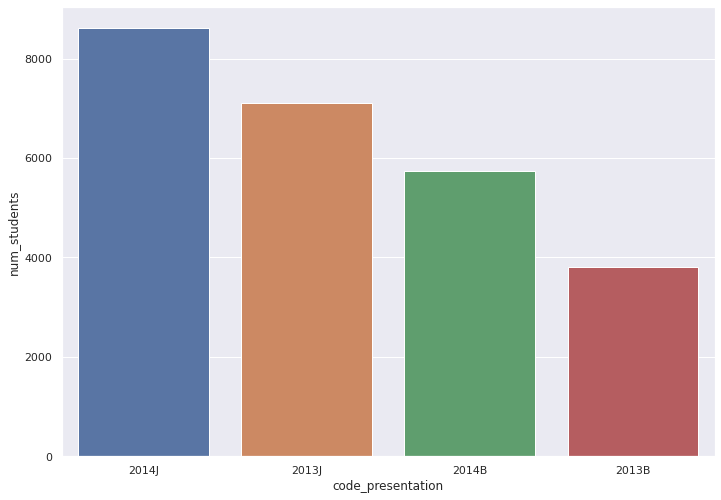

In [59]:
sns.barplot(data = students_by_semester, x = 'code_presentation', y = 'num_students')

Гипотеза: курс - сочетание двух семестров. У первого семестра на конце j, у второго - b. Это можно предположить исходя из того, что студентов j > b. Для проверки гипотезы можно посмотреть на распределение регистраций на курсы.

In [65]:
studentRegistration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


In [66]:
registration_by_semester = (studentRegistration.groupby("code_presentation", as_index = False)
                                               .agg(registration_count = ('id_student', 'nunique'))
                                               .sort_values('registration_count', ascending = False))

In [69]:
registration_by_semester.head()

,code_presentation,registration_count
3,2014J,10670
1,2013J,8830
2,2014B,7333
0,2013B,4679


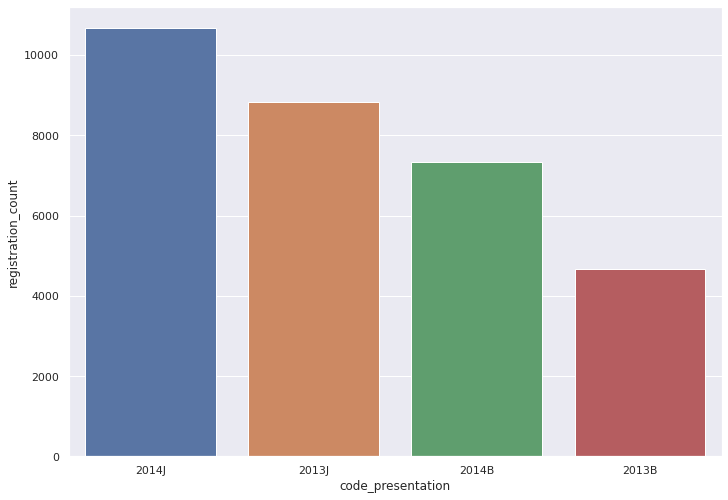

In [68]:
sns.barplot(data = registration_by_semester, x = 'code_presentation', y = 'registration_count')


Можно заметить, что тут ситуация идентичная.Количество регистраций на семестр j > b. Буду считать, что курс состоит из 2 семестров (1 - j(зимний), 2 - b(летний))



/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


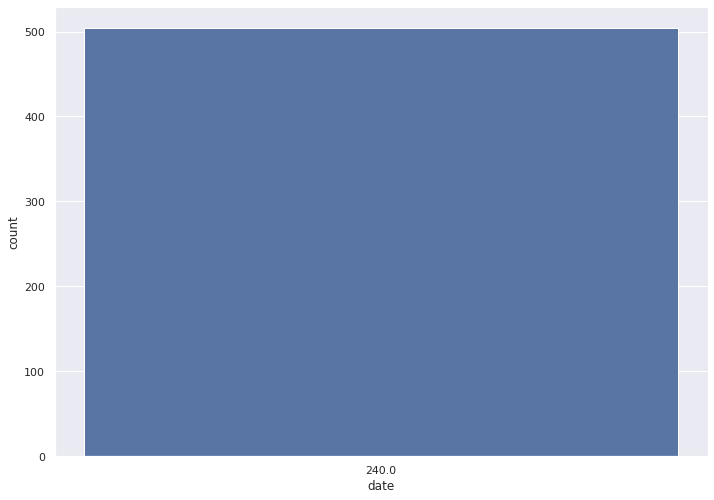

In [114]:
sns.countplot(successful_course.query("code_presentation == '2013B'").date)


/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


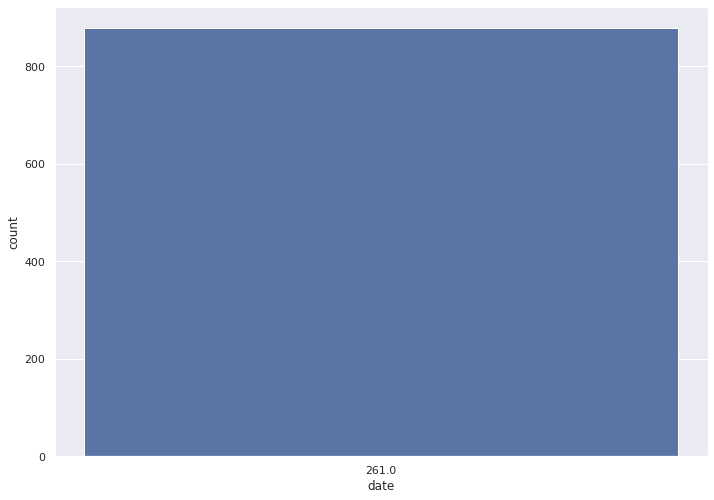

In [115]:
sns.countplot(successful_course.query("code_presentation == '2013J'").date)

Посмотрев на дату сдачи экзамена можно сделать вывод, что все-таки курс состоит из двух модулей, но первым является летний (B), второй - зимний(j). Интересно, что количество студентов и регистраций с продвижением по учебе не уменьшается, а увеличивается. Можно предположить, что на курсе нестрогий набор и люди могут присоединиться посреди обучения.

??????????????????